# Classifying faces using Convolutional neural networks

Convolutional neural networks are routinely used to classify images. Here's a rudimentary workflow that can be used to classify faces. In this notebook, the images obtained from this challenge were used to classify them into three categories according to their ages.
The dataset consists of images of people labelled with their ages. The typical images are frontal shots which contain the face of the person. Since we plan to classify images according to facial features, we isolate and crop out the image of the face and store it on the disk as a separate png file. These files are then used to train the network.

# 1. DATASET

The dataset consists of 2476 labelled images from the CHALearn "Looking at people" dataset for the ["Apparent age V2 (CVPR '16)" challenge](http://chalearnlap.cvc.uab.es/dataset/19/description/).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 3 columns):
Filename    4112 non-null object
Age         4112 non-null float32
Std         4112 non-null float32
dtypes: float32(2), object(1)
memory usage: 64.4+ KB
None


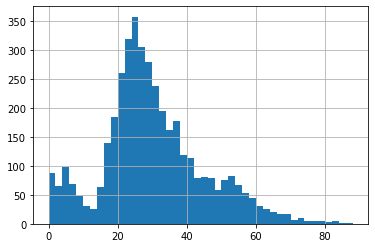

In [2]:
import pandas as pd
import numpy as np
labels=pd.read_csv('train_gt.csv',sep=',',header=1,names=['Filename','Age','Std'], dtype={'Filename':str , 'Age':np.float32 , 'Std':np.float32 }  )
#labels['Age_category'],agebins=pd.qcut(labels['Age'],3,labels=False,retbins=True)
print(labels.info())
labels['Age'].hist(bins=np.arange(0,90,2))

Let's filter out the faces of adults since those look significantly similar than the children/teenagers.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3486 entries, 0 to 4111
Data columns (total 3 columns):
Filename    3486 non-null object
Age         3486 non-null float32
Std         3486 non-null float32
dtypes: float32(2), object(1)
memory usage: 81.7+ KB
None


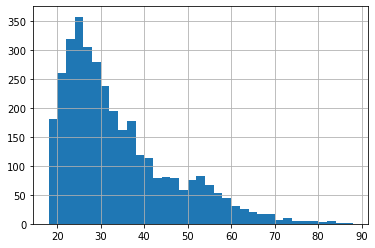

In [3]:
labels_adults=labels.loc[labels['Age']>18.0]
print(labels_adults.info())
labels_adults['Age'].hist(bins=np.arange(18,90,2))

### Let's sort the dataset into three equally sized groups by age

In [4]:
labels_adults['Age_category'],agebins=pd.qcut(labels_adults['Age'],3,labels=False,retbins=True)

/home/prasadb/miniconda3/envs/tf-graphViz/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [5]:
print(agebins)

[18.04347801 26.22940254 36.25555547 89.15384674]


In [6]:
labels_adults.head()

,Filename,Age,Std,Age_category
0,001060.jpg,35.462963,4.901674,1
1,003987.jpg,20.136364,3.671703,0
2,002290.jpg,68.538460,7.203440,2
3,001969.jpg,28.933332,6.702901,1
4,003617.jpg,24.928572,6.318502,0


## 2. Cropping out the face from the images

We will be using the Haar Cascade filters available in openCV to filter out the face. This filter typically identifies a few parts of the image as the face. We choose the largest such part as the face.

In [7]:
import cv2
cascPath="/home/prasadb/miniconda3/envs/tf-graphViz/lib/python3.6/site-packages/cv2/data/haarcascade_frontalface_default.xml"
eyePath="/home/prasadb/miniconda3/envs/tf-graphViz/lib/python3.6/site-packages/cv2/data/haarcascade_eye.xml"
smilePath="/home/prasadb/miniconda3/envs/tf-graphViz/lib/python3.6/site-packages/cv2/data/haarcascade_smile.xml"

faceCascade = cv2.CascadeClassifier(cascPath)
eyeCascade = cv2.CascadeClassifier(eyePath)
smileCascade = cv2.CascadeClassifier(smilePath)

In [8]:
def calcarea(a):
    return a[2]*a[3]

In [21]:
!mkdir Faces
!mkdir Faces/0
!mkdir Faces/1
!mkdir Faces/2

In [23]:
for ir in labels_adults.itertuples():
    tempimage=cv2.imread(str('train/'+ ir[1]),cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    try:
        gray_img = cv2.cvtColor(tempimage, cv2.COLOR_BGR2GRAY)#Image is converted to gray-scale for face detection
    except: ## Discard image if it is already grayscale
        print(str('--------------------------------------------------'))
        print(str(ir[0])+' '+str(ir))
        print(str(ir[0])+' '+str(tempimage.shape))
        print(tempimage.max())
        print(tempimage.min())
        print(str('--------------------------------------------------'))

    faces = faceCascade.detectMultiScale(gray_img,scaleFactor=1.1,minNeighbors=5,flags=cv2.CASCADE_SCALE_IMAGE)
    #print(type(faces))
    if( isinstance(faces,tuple)):
        if(len(faces)==0):
            continue ## No Faces detected
        else:
            maxA=0
            face1=tempimage[faces[1]:faces[1]+faces[3],faces[0]:faces[0]+faces[2]]
    else:
        maxA = np.apply_along_axis(calcarea,1,faces).argmax()
        face1=tempimage[faces[maxA][1]:faces[maxA][1]+faces[maxA][3],faces[maxA][0]:faces[maxA][0]+faces[maxA][2]]
    filename=str('Faces/'+str(ir[4])+'/' +str(int(ir[0]))+ str(ir[1][0:-4]) + '.png' )
    try:
        cv2.imwrite(filename,face1)
    except:
        print(str('-----Write Error----------------------------------'))
        print(str(ir[0])+' '+str(ir))
        print(filename)
        print(face1.shape)
        

--------------------------------------------------
343 Pandas(Index=343, Filename='001538.jpg', Age=32.82352828979492, Std=6.500998020172119, Age_category=1)
343 (480, 321)
255
0
--------------------------------------------------
--------------------------------------------------
419 Pandas(Index=419, Filename='003257.jpg', Age=27.585186004638672, Std=4.556452751159668, Age_category=1)
419 (158, 135)
255
0
--------------------------------------------------
--------------------------------------------------
579 Pandas(Index=579, Filename='001249.jpg', Age=25.91666603088379, Std=4.462031364440918, Age_category=0)
579 (1175, 800)
255
0
--------------------------------------------------
-----Write Error----------------------------------
579 Pandas(Index=579, Filename='001249.jpg', Age=25.91666603088379, Std=4.462031364440918, Age_category=0)
Faces/0/579001249.png
(0, 0)
--------------------------------------------------
986 Pandas(Index=986, Filename='002201.jpg', Age=35.26315689086914, St

## Repeating the same steps on validation data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 3 columns):
Filename    4112 non-null object
Age         4112 non-null float32
Std         4112 non-null float32
dtypes: float32(2), object(1)
memory usage: 64.4+ KB
None


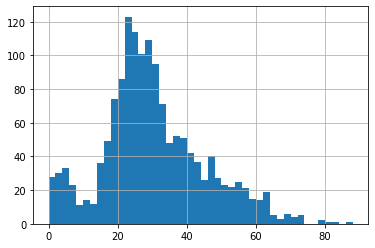

In [24]:
valid_labels=pd.read_csv('valid_gt.csv',sep=',',header=1,names=['Filename','Age','Std'], dtype={'Filename':str , 'Age':np.float32 , 'Std':np.float32 }  )
#labels['Age_category'],agebins=pd.qcut(labels['Age'],3,labels=False,retbins=True)
print(labels.info())
valid_labels['Age'].hist(bins=np.arange(0,90,2))

In [25]:
valid_labels_adults=valid_labels.loc[valid_labels['Age']>18.0]

def sort_valid_labels(row):
    if row['Age']<agebins[1]:
        return 0
    elif (row['Age']>= agebins[1]) and (row['Age']<agebins[2]):
        return 1
    elif (row['Age']>=agebins[2]):
        return 2

valid_labels_adults['Age_category']=valid_labels_adults.apply(sort_valid_labels,1)
        

/home/prasadb/miniconda3/envs/tf-graphViz/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [26]:
valid_labels_adults.head()

,Filename,Age,Std,Age_category
1,004519.jpg,31.394737,5.598588,1
2,004997.jpg,39.250000,5.422341,2
3,004871.jpg,29.692308,5.566170,1
4,004839.jpg,28.117647,3.797043,1
5,004180.jpg,23.739130,2.591246,0


In [27]:
!mkdir valid_Faces
!mkdir valid_Faces/0
!mkdir valid_Faces/1
!mkdir valid_Faces/2

In [28]:
for ir in valid_labels_adults.itertuples():
    tempimage=cv2.imread(str('valid/'+ ir[1]),cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    try:
        gray_img = cv2.cvtColor(tempimage, cv2.COLOR_BGR2GRAY)#Image is converted to gray-scale for face detection
    except: ## Discard image if it is already grayscale
        print(str('--------------------------------------------------'))
        print(str(ir[0])+' '+str(ir))
        print(str(ir[0])+' '+str(tempimage.shape))
        print(tempimage.max())
        print(tempimage.min())
        print(str('--------------------------------------------------'))

    faces = faceCascade.detectMultiScale(gray_img,scaleFactor=1.1,minNeighbors=5,flags=cv2.CASCADE_SCALE_IMAGE)
    #print(type(faces))
    if( isinstance(faces,tuple)):
        if(len(faces)==0):
            continue ## No Faces detected
        else:
            maxA=0
            face1=tempimage[faces[1]:faces[1]+faces[3],faces[0]:faces[0]+faces[2]]
    else:
        maxA = np.apply_along_axis(calcarea,1,faces).argmax()
        face1=tempimage[faces[maxA][1]:faces[maxA][1]+faces[maxA][3],faces[maxA][0]:faces[maxA][0]+faces[maxA][2]]
    filename=str('valid_Faces/'+str(ir[4])+'/' +str(int(ir[0]))+ str(ir[1][0:-4]) + '.png' )
    try:
        cv2.imwrite(filename,face1)
    except:
        print(str('-----Write Error----------------------------------'))
        print(str(ir[0])+' '+str(ir))
        print(filename)
        print(face1.shape)
        

--------------------------------------------------
247 Pandas(Index=247, Filename='004503.jpg', Age=21.365385055541992, Std=4.146494388580322, Age_category=0)
247 (223, 144)
255
0
--------------------------------------------------
--------------------------------------------------
753 Pandas(Index=753, Filename='004645.jpg', Age=43.54999923706055, Std=7.813290119171143, Age_category=2)
753 (679, 523)
255
0
--------------------------------------------------


In [29]:
!for i in `seq 0 2` ; do echo -n "Folder ${i} \nNo. of Files: " ; ls Faces/${i}/ | wc -l ; done

Folder 0 
No. of Files: 1006
Folder 1 
No. of Files: 1038
Folder 2 
No. of Files: 1058
